Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [1]:
import cnn_builder as cbuild
import cnn_methods as cfunc
import config
import csv
import dr_methods as drm
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import time
import transforms as tr
import voi_methods as vm
%matplotlib inline

Using TensorFlow backend.


In [29]:
importlib.reload(cbuild)
importlib.reload(cfunc)
importlib.reload(config)
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

# Reload images and VOIs

In [ ]:
drm.load_all_vois(C)

In [186]:
for cls in C.classes_to_include:
    if not os.path.exists(C.full_img_dir + "\\" + cls):
        os.makedirs(C.full_img_dir + "\\" + cls)
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [21]:
#dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls",
                                     "flipz", "real_dx", "real_dy", "real_dz", "id", "lesion_num"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
patient_info_df = pd.DataFrame(columns = ["MRN", "Sex", "AccNum", "AgeAtImaging", "cls"])

voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)

In [33]:
#intensity_df = pd.read_csv(C.int_df_path)

intensity_df = drm.get_intensities(C)
intensity_df.to_csv(C.int_df_path, index=False)

In [37]:
xls_name = 'Z:\\Prototype1d.xlsx'
sheetnames = ['OPTN 5A', 'OPTN 5B', 'Cyst', 'Hemangioma', 'FNH', 'Cholangio', 'Colorectal', 'Adenoma']
cls_names = ['hcc', 'hcc', 'cyst', 'hemangioma', 'fnh', 'cholangio', 'colorectal', 'adenoma']
img_dirs = ["Z:\\"+x for x in ['OPTN5A', 'optn5b', 'simple_cysts', 'hemangioma', 'fnh', 'cholangio', 'colorectal', 'adenoma']]

for i in [sheetnames.index(x) for x in ['OPTN 5A']]:
    #drm.check_folders(img_dirs[i], xls_name, sheetnames[i], C)
    #dims_df = drm.load_imgs(img_dirs[i], cls_names[i], xls_name, sheetnames[i], dims_df, C)
    voi_dfs = load_vois(cls_names[i], xls_name, sheetnames[i], voi_dfs, dims_df, C)
    drm.load_patient_info(img_dirs[i], cls_names[i], xls_name, sheetnames[i], patient_info_df, C)

In [32]:
voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)

In [30]:
dims_df.to_csv(C.dims_df_path, index=False)

In [56]:
#drm.delete_imgs(['12916368', 'E102556695'], 'hcc', C)
#drm.delete_imgs(0, cls, C, xls_name, sheetname)
drm.reload_img("E105370029", "colorectal", C)


Loading DCM for ['E105370029']
.Overall time: 33.8552565574646


# Generate cropped imgs

In [127]:
for acc_num in ['E100992235']:
    vm.reload_accnum(acc_num, "5b", C, augment=True)


Loading VOIs for ['E100992235']
.Overall time: 2.107248306274414


In [ ]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
intensity_df = pd.read_csv(C.int_df_path)

#C.classes_to_include = ['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']

In [103]:
with open(C.small_voi_path, 'r') as csv_file:
    reader = csv.reader(csv_file)
    small_vois = dict(reader)
for key in small_vois:
    small_vois[key] = [int(x) for x in small_vois[key][1:-1].split(', ')]

In [ ]:
small_vois = {}
small_vois = vm.extract_vois(small_vois, C, voi_df_art, voi_df_ven, voi_df_eq, intensity_df)

with open(C.small_voi_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in small_vois.items():
        writer.writerow([key, value])

In [184]:
# scaled imgs
t = time.time()
for cls in C.classes_to_include:
    for fn in os.listdir(C.crops_dir + cls):
        img = np.load(C.crops_dir + cls + "\\" + fn)
        unaug_img = vm.resize_img(img, C.dims, small_vois[fn[:-4]])
        np.save(C.orig_dir + cls + "\\" + fn, unaug_img)
print(time.time()-t)

for cls in C.classes_to_include:
    vm.save_all_vois(cls, C)

80.39607095718384


In [ ]:
# augmented imgs
t = time.time()
for cls in C.classes_to_include:
    vm.parallel_augment(cls, small_vois, C, num_cores=3)
    print(cls, time.time()-t)

# Plotting

In [98]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "E104978772.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
240,E104978772.npy,145,180,241,271,61,77,hcc,False,33.806817,28.977272,31.999971,E104978772_0,0
241,E104978772.npy,102,123,169,195,26,33,hcc,False,20.284090,25.113636,13.999987,E104978772_1,1


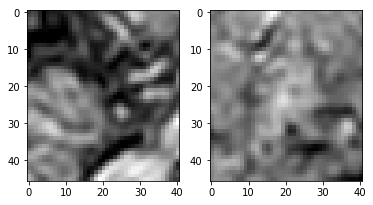

In [101]:
# can be used to determine if an image is flipped
cls = "hcc"
acc_num = 'E104978772'#acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+cls + "\\"+img_fn)
hf.plot_section(img, voi_df_art[voi_df_art["Filename"] == img_fn].iloc[1], flipz="both", pad=10)

-1.0 1.0 -0.0823752832865


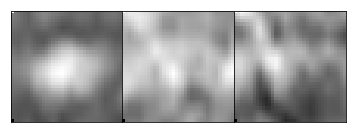

In [119]:
# Cropped, rescaled or augmented imgs
img = drm.plot_check("fnh", 2, C, "E102315724_0")
print(np.amin(img), np.amax(img), np.mean(img))

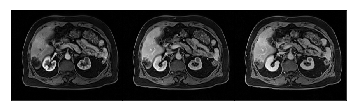

In [43]:
# Full imgs
cls = "cyst"
accnum = "13112385"
img = np.load(C.full_img_dir + "\\" + cls + "\\" + accnum + ".npy")
hf.plot_section_auto(img)

# Run CNN

In [ ]:
cbuild.overnight_run(C)

In [ ]:
#early_stopping = EarlyStopping(monitor='acc', min_delta=0.01, patience=4)
train_generator = cbuild.train_generator_func(C, train_ids, voi_df, avg_X2, n=5, n_art=3)
hist = model.fit_generator(train_generator, steps_per_epoch=200, epochs=15)#, callbacks=[early_stopping])

In [ ]:
n = 8
n_art = 0
steps_per_epoch = 200
epochs = 15
run_2d = False
batch_norm = True
non_imaging_inputs = True
f = [64,128,128,128]
dense_units = 100
dilation_rate = (1, 1, 1)
kernel_size = (3,3,3)
activation_type = 'elu'

t = time.time()

model = cbuild.build_cnn(C, 'adam', activation_type=activation_type,
        dilation_rate=dilation_rate, f=f,
        dense_units=dense_units, kernel_size=kernel_size)

model, X_test, Y_test, loss_hist, num_samples = cbuild.run_cnn(model, C, n=n, n_art=n_art,
            steps_per_epoch=steps_per_epoch, epochs=epochs, run_2d=run_2d)

Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])
print("6cls accuracy:", accuracy_score(y_true, y_pred))

y_true_simp, y_pred_simp, _ = cfunc.condense_cm(y_true, y_pred, C.classes_to_include)
print("3cls accuracy:", accuracy_score(y_true_simp, y_pred_simp))


# Situational

for img_fn in os.listdir(C.full_img_dir):
    try:
        cls = voi_df_art[voi_df_art["Filename"] == img_fn]["cls"].values[0]
        os.rename(C.full_img_dir + "\\" + img_fn, C.full_img_dir + "\\" + cls + "\\" + img_fn)
    except:
        continue

In [76]:
df = pd.read_excel(xls_name, sheetname)
df = drm.preprocess_df(df, C)
acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

In [ ]:
xls_name = 'Z:\\Prototype1d.xlsx'
img_dir = "Z:\\cholangio"
cls = 'cholangio'
sheetname="Cholangio"
df = pd.read_excel(xls_name, sheetname)
accnums = df[df['Run'] > C.run_num]['Patient E Number'].values

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" in img_fn:
            os.remove(C.aug_dir + cls + "\\" + img_fn)

img = img * 2 - 1

for cls in C.classes_to_include:
    fns = os.listdir(C.crops_dir + cls)
    for fn in fns:
        img = np.load(C.crops_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.crops_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.orig_dir + cls)
    for fn in fns:
        img = np.load(C.orig_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.orig_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.aug_dir + cls)
    for fn in fns:
        img = np.load(C.aug_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.aug_dir + cls + "\\" + fn, img)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" not in img_fn:
            img = np.load(C.aug_dir + cls + "\\" + img_fn)
            aug_img = tr.generate_reflected_img(img)
            np.save(C.aug_dir + cls + "\\" + img_fn[:-4] + "-refl", aug_img)